### Ejemplos de diferenciación automática con escalares

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Clase ``Scalar``:

In [2]:
class Scalar(object):
    def __init__(self, x):
        self.value = x
        self.args = []
        self.grad = 0

    def backward(self, grad):
        self.grad += grad

    def reset_grad(self):
        self.grad = 0

    def __add__(self, other):
        return Sum(self, other)

    def __sub__(self, other):
        return Subtract(self, other)

    def __mul__(self, other):
        return Product(self, other)

    def __pow__(self, other):
        return Pow(self, other)

Operaciones aritméticas:

In [3]:
class Sum(Scalar):
    def __init__(self, arg0, arg1):
        super().__init__(arg0.value + arg1.value)
        self.args = [arg0, arg1]

    def backward(self, grad):
        super().backward(grad)
        self.args[0].backward(grad)
        self.args[1].backward(grad)


class Subtract(Scalar):
    def __init__(self, arg0, arg1):
        super().__init__(arg0.value - arg1.value)
        self.args = [arg0, arg1]

    def backward(self, grad):
        super().backward(grad)
        self.args[0].backward(grad)
        self.args[1].backward(-grad)


class Product(Scalar):
    def __init__(self, arg0, arg1):
        super().__init__(arg0.value * arg1.value)
        self.args = [arg0, arg1]

    def backward(self, grad):
        super().backward(grad)
        self.args[0].backward(grad*self.args[1].value)
        self.args[1].backward(grad*self.args[0].value)



Potencia, exponencial y sigmoide:

In [4]:
class Pow(Scalar):
    def __init__(self, arg0, n):
        super().__init__(arg0.value**n)
        self.args = [arg0]
        self.n = n

    def backward(self, grad):
        super().backward(grad)
        self.args[0].backward(grad * self.n * self.args[0].value**(self.n - 1))

def pow(x, y):
    return Pow(x, y)


class Exp(Scalar):
    def __init__(self, arg0):
        super().__init__(np.exp(arg0.value))
        self.args = [arg0]

    def backward(self, grad):
        super().backward(grad)
        self.args[0].backward(grad*self.value)

def exp(x):
    return Exp(x)


class Sigmoid(Scalar):
    def __init__(self, arg0):
        super().__init__(1 / (1 + np.exp(-arg0.value)))
        self.args = [arg0]

    def backward(self, grad):
        super().backward(grad)
        self.args[0].backward(grad*self.value*(1-self.value))

def sigmoid(x):
    return Sigmoid(x)



Ejemplo función $y = xz^{2} + z$:

In [5]:
x = Scalar(2)
z = Scalar(3)
y = x*z**2 + z

In [6]:
print(y.value)

21


In [7]:
y.backward(1)
print(x.grad)
print(z.grad)

9
13


Ejemplo función:

In [8]:
def f(x):
  y = Scalar(3)*x**2
  return y

In [9]:
def derivada(f, x):
  y = f(x)
  y.backward(1)
  return x.grad

In [10]:
f(Scalar(10)).value

300

In [11]:
derivada(f, Scalar(10))

60

In [12]:
x = np.arange(-10, 10, 0.01)
y = np.array([f(Scalar(z)).value for z in x])
dy = np.array([derivada(f, Scalar(z)) for z in x])

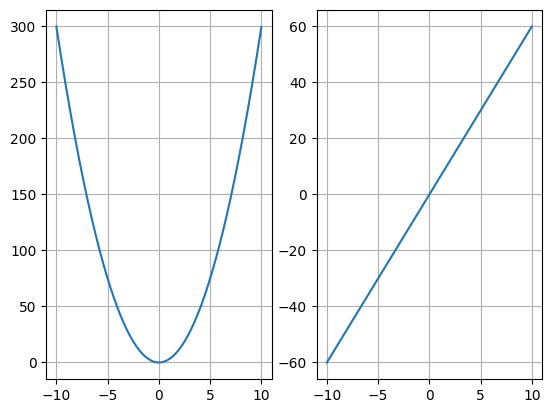

In [13]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(x, y)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(x, dy)
plt.grid(True)
plt.show()

Ejemplo regresión lineal:

In [17]:
from functools import reduce
from operator import add

In [22]:
# Parameters:
a = 2.0
b = 1.0
xmin = 0.0
xmax = 10.0
noise = 2.0
n = 100

# Randomly generated problem data:
x = xmin + np.random.rand(n)*(xmax - xmin)
t = a*x + b + np.random.randn(n)*noise

In [26]:
w = np.random.randn()
b = np.random.randn()

In [27]:
num_iters = 25 # number of iterations
eta = 0.0001 # learning rate
ehistory = []
for i in range(num_iters):
    wsc = Scalar(w)
    bsc = Scalar(b)
    y = [wsc*Scalar(z) + bsc for z in x]
    y_minus_t = [a - Scalar(b) for a, b in zip(y, t)]

    ei = [a**2 for a in y_minus_t]
    e = reduce(add, ei)
    ehistory.append(e.value)

    e.backward(1)
    w -= eta*wsc.grad
    b -= eta*bsc.grad

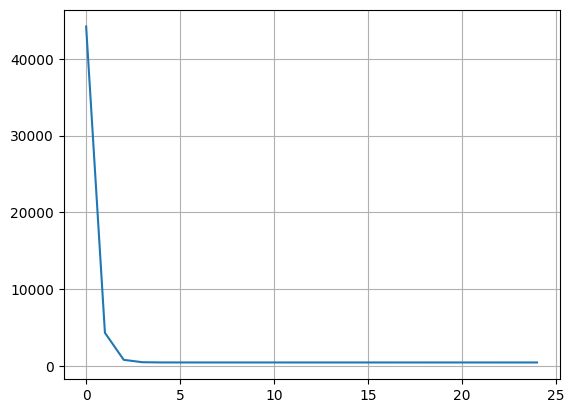

In [29]:
plt.figure()
plt.plot(ehistory)
plt.grid(True)
plt.show()

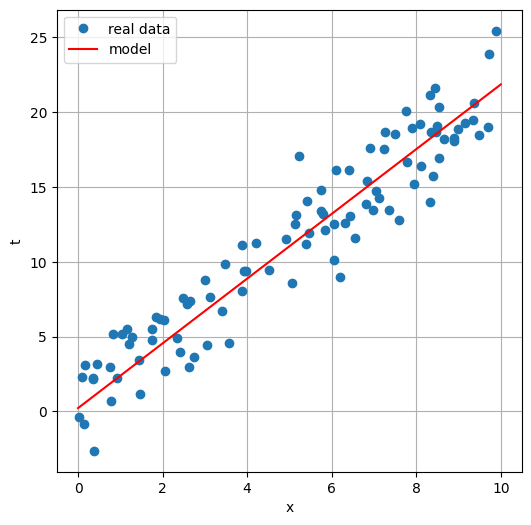

In [28]:
plt.figure(figsize=(6, 6))
plt.plot(x, t, 'o', label='real data')
plt.plot([xmin, xmax], [w*xmin + b, w*xmax + b], 'r-', label='model')
plt.grid(True)
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()